<a href="https://colab.research.google.com/github/johnhallman/ctsb/blob/tutorials/tutorials/notebooks/QuickStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart into CTSB

In [1]:
!git clone https://github.com/johnhallman/ctsb.git

Cloning into 'ctsb'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 3805 (delta 4), reused 0 (delta 0), pack-reused 3785
Receiving objects: 100% (3805/3805), 8.82 MiB | 27.30 MiB/s, done.
Resolving deltas: 100% (2548/2548), done.


In [2]:
!pip install -e ctsb

Obtaining file:///content/ctsb
     |████████████████████████████████| 204kB 2.8MB/s 
     |████████████████████████████████| 23.8MB 1.9MB/s 
     |████████████████████████████████| 40kB 16.7MB/s 
     |████████████████████████████████| 61kB 16.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/1b/2f/52/6be8e30705d02706282ba8880592670cdbdd686ac2fc04404c
  Stored in directory: /root/.cache/pip/wheels/f0/ff/63/fdbff3f1e1b76ad4eae491dd5b190902906b093e93eb86dd5a
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built jax memory-profiler opt-einsum
  Running setup.py develop for ctsb


Welcome to CTSB! This is a short tutorial to get you started with the framework. First, start by installing the package from GitHub using pip or pip3.

Import CTSB as with any other Python package

In [0]:
import ctsb
ctsb.set_key(0) # random seeding makes CTSB deterministic

You are now ready to get started!

# Problems: Load Different Tasks
The Problem class is the abstraction used to implement control and time series tasks. CTSB comes pre-loaded with several classical problems (both simulated and real world data) such as ARMA time series or linear dynamical systems. Below we demonstrate how to initialize a problem and step through the simulated time series generated by an ARMA. The initialize() method returns the initial observation. We can also query the hidden state of the system.


In [6]:
import jax.numpy as np
import matplotlib.pyplot as plt

# create a time-series problem instance
T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
problem.initialize(p,q)

# run problem for T time-steps
test_output = []
for t in range(T):
    test_output.append(problem.step())
    
hidden = problem.hidden()
print("Hidden state: {}".format(hidden))

# plot the resulting time-series
plt.plot(test_output)
plt.title("arma")
plt.show()

AttributeError: ignored

*The* help() method provides more info about the API of a certain Problem class.

In [0]:
problem.help()

# Models: Pre-implemented Algorithms for Solving Problems
The Model class is the abstraction used to implement models/predictors for the problems. CTSB is designed so that the Model and Problem classes can be combined in a modular fashion. Roughly speaking, the goal of CTSB is to be able to test an arbitrary model on an arbitrary problem, at least when it makes sense to do so. For example, below we show how to combine a basic last-value model (a predictor that just outputs the previous observation) for time-series on the ARMA problem.

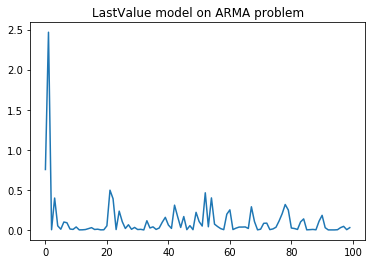

In [6]:
# create problem instance and specify loss
T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
cur_x = problem.initialize(p, q)
loss = lambda y_true, y_pred: (y_true - y_pred)**2

# create model
model = ctsb.model("LastValue")
model.initialize()

# run model for T time-steps
results = []
for i in range(T):
    cur_y_pred = model.predict(cur_x)
    cur_y_true = problem.step()
    cur_loss = loss(cur_y_true, cur_y_pred)
    results.append(cur_loss)
    model.update(cur_y_true)
    cur_x = cur_y_true

# plot model performance
plt.plot(results)
plt.title("LastValue model on ARMA problem")
plt.show()


# The Problem and Model Registry
Each of the Problem and Model classes included in CTSB are inserted into a global registry, which is dict from a unique string to the Problem/Model class corresponding to the string. The registry supports versioning, so that multiple versions of a certain Problem/Model can be referenced. For example, the id "ARMA-v0" is the registry id for version 0 of the ARMA problem. The previous example shows how to create instances of problem and model via the corresponding registry ids. A comprehensive list of all Problem and Model ids can be printed by printing out by calling ctsb.help()


In [0]:
ctsb.help()

# Creating and Registering Custom Models
In order to add a new algorithm to the registry, you must first implement a CustomModel object that adheres to the specifications of the other CTSB models. As long as your class inherits the ctsb CustomClass object and has the three core CTSB Model methods implemented — *initialize*, *predict*, and *update* — the class will interface as expected with all the other features in the framework. These methods are:

*   Initialize — initializes model parameters and other local variables, and is called at the beginning of every problem run
*   Predict — a function that takes an input observation 'x' and returns a prediction which can depend on the parameters defined in initialize
*   Update — which takes the true label with respect to the last observed value 'x' and performs some correction over the initialized parameters.

The output of the predict method will vary depending on the task of your model. Below, we implement a simple time-series prediction model based on the CustomModel class.


In [0]:
class MyModel(ctsb.CustomModel):
  
  def initialize(self, parameter): # here parameter is a single scalar value
    self.parameter = parameter 
  
  def predict(self, x): # return next time-step prediction
    self.y_pred = x + self.parameter
    return self.y_pred 
  
  def update(self, y_true): # adjust parameter
    self.parameter -= 0.01 * (self.y_pred - y_true) 

CTSB comes with a built in ```register_custom_model``` method that allows users to register model classes with custom names.

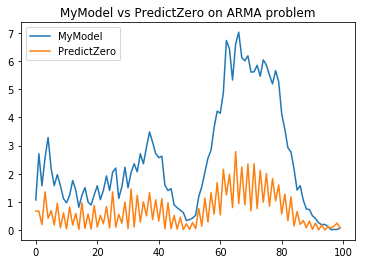

In [8]:
import matplotlib.pyplot as plt

# add MyModel to the model registry
ctsb.register_custom_model(MyModel, "NameOfMyModel")

# we can now use it as with any other model
my_model = ctsb.model("NameOfMyModel")
my_model.initialize(parameter=0.0)

# test model on ARMA problem and compare to PredictZero
T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
cur_x = problem.initialize(p, q)
loss = lambda y_true, y_pred: (y_true - y_pred)**2
pz_model = ctsb.model("PredictZero")
pz_model.initialize()

my_results = []
pz_results = []
for i in range(T):
    my_y_pred = my_model.predict(cur_x)
    pz_y_pred = pz_model.predict(cur_x)
    y_true = problem.step()
    my_loss = loss(y_true, my_y_pred)
    pz_loss = loss(y_true, pz_y_pred)
    my_results.append(my_loss)
    pz_results.append(pz_loss)
    my_model.update(y_true)
    pz_model.update(y_true)
    cur_x = y_true

# plot model performance
plt.plot(my_results, label="MyModel")
plt.plot(pz_results, label="PredictZero")
plt.legend()
plt.title("MyModel vs PredictZero on ARMA problem")
plt.show()


Our class can now be find in the registry as well. 

In [0]:
print(ctsb.model_registry.list_ids())

['LastValue', 'AutoRegressor', 'PredictZero', 'KalmanFilter', 'TD3', 'ShootingMethod', 'NameOfMyModel']


# Experiments: Evaluate Models Automatically
The Experiment class allows the automated testing of combination of various models against various problems. It supports plotting the loss functions for the various (problem, model) trials. Below we demonstrate how to setup an experiment to test every problem from a list of problems against every model from a list of models. See the Experiments tutorial for further information on the initialize parameters. The scoreboard method shows average loss for each trial. The graph method plots the loss curves.

Scoreboard for mse:
+-----------------+-------------+-------------+---------------+
| Problems\Models | PredictZero |  LastValue  | AutoRegressor |
+-----------------+-------------+-------------+---------------+
|    Random-v0    |  1.0155556  |  1.9577228  |   0.7940691   |
|     ARMA-v0     |  47.549088  |  1.3473058  |   0.34262234  |
|     SP500-v0    |  51618.754  |   448.8535  |      nan      |
|    Crypto-v0    |   11535.31  |  231.77095  |      nan      |
|     ENSO-v0     |  0.2731384  | 0.031695034 |   0.27031517  |
+-----------------+-------------+-------------+---------------+


/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


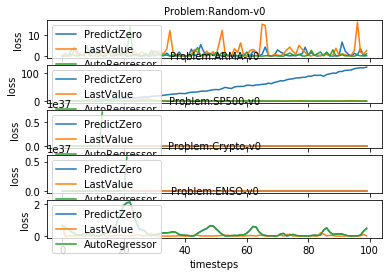

In [9]:
import ctsb
from ctsb.experiments import Experiment

def test_new_experiment(steps=100, show=False):
    exp = Experiment()
    exp.initialize(problems = ['Random-v0', 'ARMA-v0', 'SP500-v0', 'Crypto-v0', 'ENSO-v0'], \
        models =  ['PredictZero', 'LastValue', 'AutoRegressor'], use_precomputed = False, \
        timesteps = steps, verbose = show, load_bar = show)
    exp.run()
    exp.scoreboard()
    exp.graph()

test_new_experiment()

# Random Seeding
As you may have observed from the beginning of the notebook, CTSB utilizes seeding implemented by jax.random in order to enforce reproducibility of experiment results. By setting a global random key at the beginning of a program, right after ctsb is imported, the random number generators used in all the problems and models become deterministic. Below, we demonstrate how to reproduce the same experiment twice by calling set_key().

/usr/local/lib/python3.6/dist-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


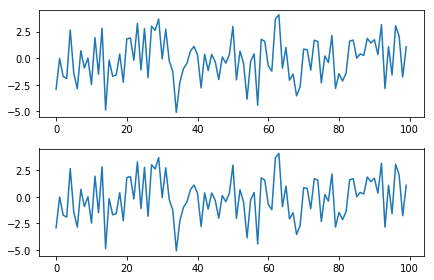

In [10]:
import jax.random as random
from ctsb.utils.random import generate_key, set_key

key = 2019 # arbitrary integer value
T = 100
n, m, d = 5, 1, 10
problem = ctsb.problem("LDS-v0")

# set the key and run experiment once
set_key(key)
problem.initialize(n, m, d)
test_output = []
for t in range(T):
    u = random.normal(generate_key(),shape=(n,))
    test_output.append(problem.step(u))

# use the same key and run again
set_key(key)
problem.initialize(n, m, d)
test_output_2 = []
for t in range(T):
    u = random.normal(generate_key(),shape=(n,))
    test_output_2.append(problem.step(u))

# plot results
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(test_output)
ax[1].plot(test_output_2)

fig.tight_layout()
plt.show()

You are now ready to benchmark your algorithm of choice using CTSB!